# MIDI Rhythm Analysis

This notebook demonstrates how to analyze rhythm patterns in MIDI files using Python. We'll use the following libraries:
- `pretty_midi`: For reading and processing MIDI files
- `numpy`: For numerical computations
- `matplotlib`: For visualization
- `librosa`: For additional music analysis tools

In [1]:
# Install required packages
!pip install pretty_midi numpy matplotlib librosa

In [2]:
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
import librosa
from collections import defaultdict

## 1. Load and Process MIDI File

First, we'll create functions to load and process MIDI files.

In [3]:
def load_midi(midi_path):
    """Load a MIDI file and return a PrettyMIDI object"""
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        return midi_data
    except Exception as e:
        print(f"Error loading MIDI file: {e}")
        return None

def extract_note_events(midi_data):
    """Extract note events from all instruments in the MIDI file"""
    note_events = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            note_events.append({
                'start': note.start,
                'end': note.end,
                'duration': note.end - note.start,
                'pitch': note.pitch,
                'velocity': note.velocity,
                'instrument': instrument.program
            })
    return sorted(note_events, key=lambda x: x['start'])

## 2. Rhythm Analysis Functions

Now we'll create functions for analyzing various rhythmic aspects of the music.

In [4]:
def analyze_tempo_changes(midi_data):
    """Analyze tempo changes throughout the piece"""
    tempo_changes = midi_data.get_tempo_changes()
    return tempo_changes

def analyze_note_density(note_events, window_size=1.0):
    """Calculate note density over time using a sliding window"""
    if not note_events:
        return [], []
    
    max_time = max(event['end'] for event in note_events)
    time_points = np.arange(0, max_time, window_size)
    densities = []
    
    for t in time_points:
        notes_in_window = sum(1 for note in note_events 
                             if note['start'] <= t <= note['end'])
        densities.append(notes_in_window)
    
    return time_points, densities

def find_rhythm_patterns(note_events, quantization=0.25):
    """Find common rhythm patterns in the piece"""
    patterns = defaultdict(int)
    current_pattern = []
    
    for i in range(1, len(note_events)):
        ioi = round((note_events[i]['start'] - note_events[i-1]['start']) / quantization) * quantization
        current_pattern.append(ioi)
        
        if len(current_pattern) == 4:  # Look for 4-note patterns
            pattern_tuple = tuple(current_pattern)
            patterns[pattern_tuple] += 1
            current_pattern = current_pattern[1:]
    
    return patterns

## 3. Visualization Functions

Let's create functions to visualize our rhythm analysis results.

In [5]:
def plot_rhythm_analysis(midi_data, note_events):
    """Create a comprehensive visualization of rhythm analysis"""
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Note density over time
    plt.subplot(3, 1, 1)
    time_points, densities = analyze_note_density(note_events)
    plt.plot(time_points, densities)
    plt.title('Note Density Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Number of Active Notes')
    
    # Plot 2: Note onset distribution
    plt.subplot(3, 1, 2)
    onset_times = [note['start'] % 4 for note in note_events]  # Modulo 4 to show within-measure position
    plt.hist(onset_times, bins=32)
    plt.title('Note Onset Distribution (Within Measure)')
    plt.xlabel('Position in Measure')
    plt.ylabel('Number of Notes')
    
    # Plot 3: Note duration distribution
    plt.subplot(3, 1, 3)
    durations = [note['duration'] for note in note_events]
    plt.hist(durations, bins=30)
    plt.title('Note Duration Distribution')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Number of Notes')
    
    plt.tight_layout()
    plt.show()

## 4. Example Usage

Here's how to use the analysis functions with your MIDI file.


Tempo changes:
Times: [0.]
Tempos: [120.]

Most common rhythm patterns (in beats):
Pattern (0.0, 0.0, 0.0, 0.0): 19 occurrences
Pattern (0.0, 0.5, 0.0, 0.0): 10 occurrences
Pattern (0.0, 0.0, 0.5, 0.0): 9 occurrences
Pattern (0.5, 0.0, 0.0, 0.0): 9 occurrences
Pattern (0.0, 0.0, 0.0, 0.5): 8 occurrences


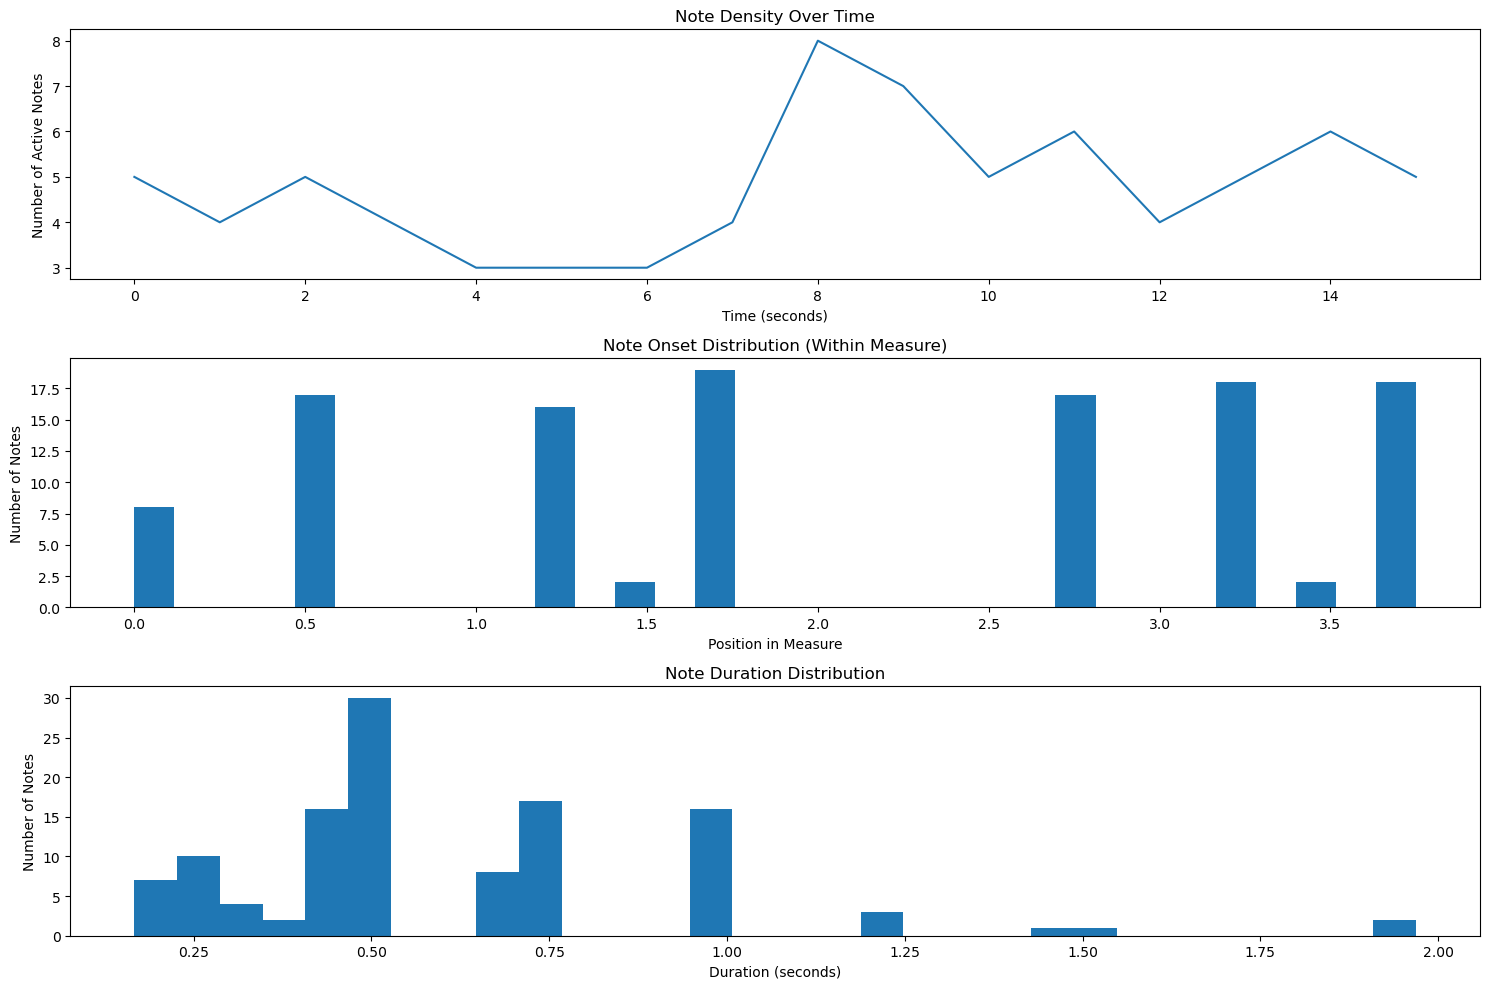

In [6]:
# Load and analyze a MIDI file
midi_path = 'piano.mid'  # Replace with your MIDI file path
midi_data = load_midi(midi_path)

if midi_data:
    # Extract note events
    note_events = extract_note_events(midi_data)
    
    # Analyze tempo changes
    tempo_changes = analyze_tempo_changes(midi_data)
    print("\nTempo changes:")
    print(f"Times: {tempo_changes[0]}")
    print(f"Tempos: {tempo_changes[1]}")
    
    # Find common rhythm patterns
    patterns = find_rhythm_patterns(note_events)
    print("\nMost common rhythm patterns (in beats):")
    for pattern, count in sorted(patterns.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"Pattern {pattern}: {count} occurrences")
    
    # Create visualizations
    plot_rhythm_analysis(midi_data, note_events)

## 5. Advanced Analysis: Groove and Syncopation

Let's add some more advanced rhythm analysis features.

In [7]:
def analyze_syncopation(note_events, beats_per_bar=4):
    """Analyze syncopation by looking at off-beat emphasis"""
    syncopation_scores = []
    
    for note in note_events:
        # Calculate position within the bar
        position_in_bar = note['start'] % beats_per_bar
        
        # Higher velocity notes on weak beats indicate syncopation
        is_strong_beat = position_in_bar % 1.0 < 0.1  # Within 0.1 of a beat
        velocity_factor = note['velocity'] / 127.0
        
        if not is_strong_beat and velocity_factor > 0.5:
            syncopation_scores.append({
                'time': note['start'],
                'score': velocity_factor * (1 - (position_in_bar % 1.0))
            })
    
    return syncopation_scores

def analyze_groove(note_events, quantization=0.125):
    """Analyze groove by measuring timing deviations from the grid"""
    groove_deviations = []
    
    for note in note_events:
        # Calculate deviation from closest quantized position
        quantized_start = round(note['start'] / quantization) * quantization
        deviation = note['start'] - quantized_start
        
        groove_deviations.append({
            'time': note['start'],
            'deviation': deviation
        })
    
    return groove_deviations

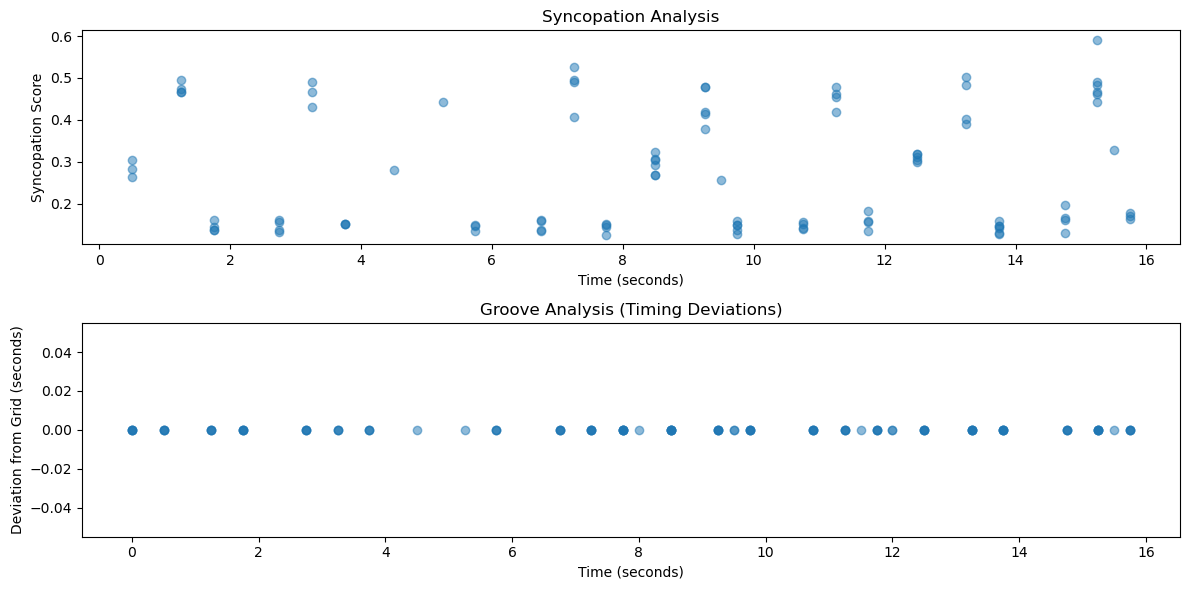

In [8]:
# Analyze groove and syncopation
if midi_data:
    syncopation_scores = analyze_syncopation(note_events)
    groove_deviations = analyze_groove(note_events)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    times = [s['time'] for s in syncopation_scores]
    scores = [s['score'] for s in syncopation_scores]
    plt.scatter(times, scores, alpha=0.5)
    plt.title('Syncopation Analysis')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Syncopation Score')
    
    plt.subplot(2, 1, 2)
    times = [g['time'] for g in groove_deviations]
    deviations = [g['deviation'] for g in groove_deviations]
    plt.scatter(times, deviations, alpha=0.5)
    plt.title('Groove Analysis (Timing Deviations)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Deviation from Grid (seconds)')
    
    plt.tight_layout()
    plt.show()